<a href="https://colab.research.google.com/github/MarshaGomez/F5-MOEA-Variations/blob/main/examples/Reinforcement_Learning_Brachistochrone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reinforcement Learning. Brachistochrone Problem

## Base Operations

### Necessary libraries

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
!apt-get install ffmpeg freeglut3-dev xvfb  # For visualization
!pip install stable-baselines3[extra]

Reading package lists... Done
Building dependency tree       
Reading state information... Done
freeglut3-dev is already the newest version (2.8.1-3).
freeglut3-dev set to manually installed.
ffmpeg is already the newest version (7:3.4.11-0ubuntu0.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  xvfb
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 784 kB of archives.
After this operation, 2,271 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.10 [784 kB]
Fetched 784 kB in 1s (1,117 kB/s)
Selecting previously unselected package xvfb.
(Reading database ... 155639 files and directories currently installed.)
Preparing to unpack .../xvfb_2%3a1.19.6-1ubuntu4.10_amd64.deb ...
Unpacking xvfb (2:1.19.6-1ubuntu4.10) ...
Setting up xvfb (2:1.19

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import os
import math
import numpy as np 
import gym
import random

from gym import spaces
from datetime import datetime, date

from stable_baselines3 import DDPG
from stable_baselines3 import TD3
from stable_baselines3 import A2C
from stable_baselines3 import PPO

from stable_baselines3.common.vec_env import VecNormalize
from stable_baselines3.ddpg.policies import MlpPolicy
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise
from stable_baselines3.common.callbacks import BaseCallback, EvalCallback
from stable_baselines3.common.env_util import make_vec_env

#from stable_baselines3.common.schedules import LinearSchedule

from scipy.optimize import newton
from scipy.integrate import quad

#for render function
from matplotlib.animation import FuncAnimation
from IPython import display

### Global Parameters

In [4]:
base_path = "/content/gdrive/My Drive/Brachistochrone/RL"
models_path = os.path.join(base_path, "saved_models/")
logs_path = os.path.join(base_path, "logs/")
tensorboard_path = os.path.join(base_path, "barchistostrone_ddpg_tensorboard")

"""SET GOAL and MODEL"""
goal = (8.0, -6.0)
#SELECTED_MODEL = 'generalized_final_'+str(Brachistochrone_Env.active_friction)+'_'+str(Brachistochrone_Env.dt)+'_'+str(Brachistochrone_Env.init_angle)+'_'+str(Brachistochrone_Env.sol_space_padding)

### Common Functions

In [5]:
def change_selected_model():
  global selected_path, best_model_path, log_path, tensorboard_log, normalization_path, stats_path, hypdict_path
  selected_path = os.path.join(models_path, SELECTED_MODEL)
  best_model_path = os.path.join(models_path, SELECTED_MODEL, "best_model")
  log_path = os.path.join(logs_path, SELECTED_MODEL, "logs")
  tensorboard_log = os.path.join(tensorboard_path, SELECTED_MODEL)
  normalization_path = os.path.join(models_path, SELECTED_MODEL, "normalizer_stat")
  stats_path = os.path.join(normalization_path, "vecnormalize.pkl")
  hypdict_path = os.path.join(models_path, SELECTED_MODEL, "HypDict.txt")

  # Check folders exist on Drive
  os.makedirs(selected_path, exist_ok=True)
  os.makedirs(best_model_path, exist_ok=True)
  os.makedirs(log_path, exist_ok=True)
  os.makedirs(tensorboard_log, exist_ok=True)
  os.makedirs(normalization_path, exist_ok=True)

In [6]:
selected_path = ""
best_model_path = ""
log_path = ""
tensorboard_log = ""
normalization_path = ""
stats_path = ""
hypdict_path = ""
SELECTED_MODEL = "generalized_final_1"

change_selected_model()

### Utility Functions

In [9]:
def cycloid(P1,P2,N):
    """Return the path of Brachistochrone curve from (0,0) to (x2, y2).
    The Brachistochrone curve is the path down which a bead will fall without
    friction between two points in the least time (an arc of a cycloid).
    It is returned as an array of N values of (x,y) between (0,0) and (x2,y2).
    """

    # First find theta2 from (x2, y2) numerically (by Newton-Rapheson).
    f = lambda theta: -P2[1]/P2[0] - (1-np.cos(theta))/(theta-np.sin(theta))
    theta2 = newton(f, np.pi/2)

    # The radius of the circle generating the cycloid.
    R = -P2[1] / (1 - np.cos(theta2))

    theta = np.linspace(0, theta2, N)
    x = R * (theta - np.sin(theta))
    y = R * (1 - np.cos(theta))

    # The time of travel
    T = theta2 * np.sqrt(R / Brachistochrone_Env.g)
    return x, y, T

def rect(P1,P2,N):
    """Return the rectilinear straight path from (0,0) to (x2, y2)."""
    x_interval = np.linspace(P1[0],P2[0],N)
    m = float(P2[1] - P1[1])/(P2[0]-P1[0])
    q = P1[1] - (m*P1[0])
    f_y = lambda x: m*x+q
    y = [f_y(x) for x in x_interval]
    T_rett = math.sqrt(2*(P2[0]**2+P2[1]**2)/(-Brachistochrone_Env.g*P2[1]))
    return x_interval,y,T_rett

def plot_solution(x,y,goal,title= None,savef=False):
    #try:
        if (len(x)!=0):
            #plot results
            cycloid_x, cycloid_y, cycloid_T = cycloid((0,0), goal, len(x))
            rect_x, rect_y, rect_T = rect((0,0), goal, len(x))
            print('Time taken by cycloid = ', cycloid_T)
            print('Time taken by linear solution = ', rect_T)
                        
            time_taken = len(x)/(1/Brachistochrone_Env.dt)
            plt.plot(x,y , label = 'Path by RL agent, time taken =  %fs' %time_taken)
            plt.plot(cycloid_x, -cycloid_y, label='Brachistochrone, time taken =  %fs' %cycloid_T)
            plt.plot(rect_x, rect_y, label='Linear, time taken =  %fs' %rect_T)
            plt.scatter(x[-1], y[-1], color = 'green', s = 100.0)
            plt.scatter(x[0], y[0], color = 'red', s = 100.0)
            plt.scatter(goal[0], goal[1], color = 'blue', s=100.0)
            plt.annotate('Start', (x[0], y[0]))
            plt.annotate('End', (x[-1], y[-1]))
            plt.annotate('Goal', goal)
            plt.legend()
            plt.xlabel('X-COORDINATE(m)')
            plt.ylabel('Y-COORDINATE(m)')
            if (title is None):
                plt.title('TRAJECTORY')
            else:
                plt.title(title)
            if (savef):
                plot_path = os.path.join(models_path, "%s/%s.png"%(title,title))
                plt.savefig(plot_path, bbox_inches='tight')
            plt.show()
        else:
            print("error: no x,y pairs provided")
    #except:
        #print("inconsistent dimensions")

        
class Schedule(object):
    def value(self, step):
        """
        Value of the schedule for a given timestep

        :param step: (int) the timestep
        :return: (float) the output value for the given timestep
        """
        raise NotImplementedError

class LinearSchedule(Schedule):
    """
    Linear interpolation between initial_p and final_p over
    schedule_timesteps. After this many timesteps pass final_p is
    returned.

    :param schedule_timesteps: (int) Number of timesteps for which to linearly anneal initial_p to final_p
    :param initial_p: (float) initial output value
    :param final_p: (float) final output value
    """

    def __init__(self, schedule_timesteps, final_p, initial_p=1.0):
        self.schedule_timesteps = schedule_timesteps
        self.final_p = final_p
        self.initial_p = initial_p

    def value(self, step):
        fraction = min(float(step) / self.schedule_timesteps, 1.0)
        return self.initial_p + fraction * (self.final_p - self.initial_p)

class SaveVecNormalizeCallback(BaseCallback):
    """
    Callback for saving a VecNormalize wrapper every ``save_freq`` steps
    :param save_freq: (int)
    :param save_path: (str) Path to the folder where ``VecNormalize`` will be saved, as ``vecnormalize.pkl``
    :param name_prefix: (str) Common prefix to the saved ``VecNormalize``, if None (default)
        only one file will be kept.
    """

    def __init__(self, save_freq: int, save_path: str, name_prefix:str = None, verbose: int = 0):
        super().__init__(verbose)
        self.save_freq = save_freq
        self.save_path = save_path
        self.name_prefix = name_prefix

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            try:
                os.makedirs(self.save_path, exist_ok=True)
            except:
                pass #folder already exist
    def _on_step(self) -> bool:
        if self.n_calls % self.save_freq == 0:
            if self.name_prefix is not None:
                path = os.path.join(self.save_path, f"{self.name_prefix}_{self.num_timesteps}_steps.pkl")
            else:
                path = os.path.join(self.save_path, "vecnormalize.pkl")
            if self.model.get_vec_normalize_env() is not None:
                self.model.get_vec_normalize_env().save(path)
                if self.verbose > 1:
                    print(f"Saving VecNormalize to {path}")
        return True

## Reinforcement Learning Process

### Brachistochrone Environment

In [10]:
#discrete action space generating theta variation in [-k;k] interval with step: 0.5
class Brachistochrone_Env(gym.Env):
    
    dt = 0.2 #HYP
    init_angle = -90.0 #define the initial value for angle of fall
    renderOnReset = False #set to false to speed up training
    active_friction = True #switch friction ON/OFF
    dynamic_friction_coeff = 0.05 #dynamic friction coefficient for friction estimation
    granularity = 0.5 #distance between subsequent angle-variation values from action space
    ylbMagnitude = 1.3 #factor to give extra-dimension along y-dim and relax feasible region
    action_space_padding = 2.5 #>1.3 factor to give more exploration capability to the agent: could be useful in constrained/alternative problems formulation
    g=10 #gravity constant
    #more params..
    
    
    def __init__(self):

        super(Brachistochrone_Env, self).__init__()
        self.states = np.array([0.0, 0.0, 0.0 ,Brachistochrone_Env.init_angle]) #pos_x, pos_y, vel, #theta from +ve x axis
        self.target_pos = np.array([+8.0, -6.0])
        self.g = -Brachistochrone_Env.g
        self.dt = Brachistochrone_Env.dt
        self.reward = 0.0
        self.tot_reward = 0.0
        self.init_err_position = math.sqrt((self.target_pos[0])**2 + (self.target_pos[1])**2)
        self.time_steps = 0
        self.renderOnReset = Brachistochrone_Env.renderOnReset
        self.action_space_padding_factor = Brachistochrone_Env.action_space_padding
        self.ylbMagnitude = Brachistochrone_Env.ylbMagnitude
        self.target_steps = self.target_steps_bounder(self.target_pos)
        self.refinementf = False
        
        
        """counter for render activity during training"""
        self.counter_rend = 200 #RENDER PROGRAMMED SWITCH-OFF
        
        self.action_seq = []
        
        #defining a feasible reward threshold according to specified dt
        self.reward_threshold = math.sqrt(0.5*Brachistochrone_Env.g*self.init_err_position)*Brachistochrone_Env.dt
        #for rendering purpose
        self.x_ep = [0]
        self.y_ep = [0]
        self.video = [(0,0)]
        
        """feasible region boundary"""
        self.x_right_boundary = self.target_pos[0]+self.reward_threshold
        self.y_lower_boundary = (Brachistochrone_Env.ylbMagnitude)*self.target_pos[1]-self.reward_threshold

        """
        act_val_high = np.array([90.0])
        act_val_low = np.array([-90.0])
        self.action_space = spaces.Box(low = act_val_low, high = act_val_high, shape = (1,), dtype=np.float32)
        """
        self.action_set, self.theta_bound = self.action_space_init(self.target_pos)
        self.action_space = spaces.Discrete(self.action_set)#discrete action space
        
        obs_val_high = np.array([100.0, 100.0, 1000.0, 0.0])
        obs_val_low = np.array([-100.0, -100.0, -1000.0,-90.0])
        self.observation_space = spaces.Box(low= obs_val_low, high = obs_val_high, shape=(4,), dtype=np.float32)
        #print(">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>"+str(self.action_space_padding_factor))

    def action_space_init(self,target_p):
        """compute k' as boundary for action space, k'> k, where k is the theoretical derivative of theta angle in optimal cycloid solution"""
        # action_set cardinality is given as a function of granularity
        
        #lower bound time to fall between starting point and goal position 
        goal_distance = self.init_err_position
        t_lb = math.sqrt(2*goal_distance / Brachistochrone_Env.g)
        #upper bound to angle variation in the path (based on theta variation)
        tot_delta_angle_ub = 180 #°
        
        angle_variation_ub = math.ceil(tot_delta_angle_ub / t_lb / (1/self.dt))
        
        granularity = Brachistochrone_Env.granularity #delta between two consecutive angles
        #action_set_cardinality = math.ceil(2* angle_variation_ub / Brachistochrone_Env.granularity) #variation
        action_set_cardinality = math.ceil(angle_variation_ub / Brachistochrone_Env.granularity)
        return action_set_cardinality, angle_variation_ub
        
    def action_discretizer(self,action_value):
        #discretization is used to vary final found solution, and is made on non-normalized action space
        disp =self.theta_bound/self.action_set
        domain = [x for x in np.arange(0,self.action_set+disp,disp)]
        action = min(domain, key=lambda x:abs(x-action_value))
        
        return action
    
    def action_space_norm(self,action):
        granularity = Brachistochrone_Env.granularity
        #action = - self.theta_bound + (action*granularity) #variation
        action = (action*granularity)
        return action
    
    def step(self, action):
        dt = self.dt
        # action corresponds to theta
        angle_variation = self.action_space_norm(action)
        original_theta = self.states[3]
        final_theta = original_theta + angle_variation

        original_vel = self.states[2]
        initial_vel_x = original_vel*math.cos(math.radians(original_theta))
        initial_vel_y = original_vel*math.sin(math.radians(original_theta))
        
        acceleration = self.g*math.sin(math.radians(final_theta)) #can be positive or negative
        
        #apply friction if needed
        if (Brachistochrone_Env.active_friction):
            #computing friction actiong along the plane
            ortogonal_acceleration = self.g*math.cos(math.radians(final_theta))
            friction_deceleration = abs(Brachistochrone_Env.dynamic_friction_coeff* ortogonal_acceleration) # always positive 
            if (acceleration>=0):
                acceleration = acceleration - friction_deceleration
            if (acceleration<0):
                acceleration = acceleration + friction_deceleration
            
        #compute x,y components of acceleration
        acceleration_x = acceleration*math.cos(math.radians(final_theta)) #
        acceleration_y = acceleration*math.sin(math.radians(final_theta)) #
        

        displacement_x = (initial_vel_x*dt) + (0.5*acceleration_x*(dt**2))
        displacement_y = (initial_vel_y*dt) + (0.5*acceleration_y*(dt**2))
        displacement = math.sqrt(displacement_x**2 + displacement_y**2)

        final_vel_x = initial_vel_x + acceleration_x*dt
        final_vel_y = initial_vel_y + acceleration_y*dt

        final_x = self.states[0] + displacement_x
        final_y = self.states[1] + displacement_y
        final_vel = math.sqrt(final_vel_x**2 + final_vel_y**2)

        self.states[0] = final_x
        self.states[1] = final_y
        self.states[2] = final_vel
        self.states[3] = final_theta

        #updating path
        self.x_ep.append(final_x)
        self.y_ep.append(final_y)
        self.video.append((final_x,final_y))

        """APPLY POLICY"""
        err_position = math.sqrt((self.states[0] - self.target_pos[0])**2 + (self.states[1] - self.target_pos[1])**2)

        #r1 define the reward for getting closer to the target 
        r1 = 1 - (err_position/self.init_err_position)
        #r2 define the reward for being fast to get the goal
        r2 = 1 - (self.time_steps/self.target_steps)
        
        """f reward weights"""
        w1= 2 #first try was 1
        w2= 1
        self.reward = w1*r1+w2*r2 # you can think to 1s as weights for scalarization method
        done=False	
        self.time_steps+=1
        if self.time_steps >= self.target_steps:
            print("fine steps")
            #if steps are over and target not reached we give a negative reward equal to negative max step reward
            self.reward = -(w1+w2) 
            #print("goodexit"+str((self.time_steps >= self.target_steps,err_position <= self.reward_threshold)))
            done = True
            
        #verificare se devo fare il replacement di last step con il passo extra
        if self.refinementf:
            #print("refinement in corso")
            #we replace last_pos with optimal inter-position
            last_pos = self.final_step_refinement()
            final_x, self.x_ep[-1], self.states[0] = last_pos[0], last_pos[0], last_pos[0]
            final_y, self.y_ep[-1], self.states[1] = last_pos[1], last_pos[1], last_pos[1]
            self.reward = (w1+w2)*(self.target_steps - self.time_steps)
            done = True
            
            
        if err_position <= self.reward_threshold and not self.refinementf:#se siamo nel cerchio target
            #print("colpito target area")
            self.refinementf = self.check_step_refinement()
            if not self.refinementf:
                done = True
            self.reward = (w1+w2)*(self.target_steps - self.time_steps)
            
        if final_x > (self.x_right_boundary) or final_x < -1.0 or final_y > 0.0 or final_y < (self.y_lower_boundary) or displacement_x<0:
            #print("bad exit")
            self.reward = -1*(w1+w2)*(self.target_steps - self.time_steps)
            #print("badexit"+str((final_x > (self.x_right_boundary),displacement_x<0)))
            done = True
        #new termination condition
        if (self.renderOnReset and self.counter_rend>0):
            print("-------|"+str(final_theta)+";"+str(self.reward)+"|--------------")

        info = {'g_component':acceleration}
        self.tot_reward +=self.reward
        #if (done==True):
            #print("<<<< n_step:%d, last_x_displacement:%f, final_x:%f >>>>>"%(self.time_steps,self.target_steps,displacement_x))
        return self.states, self.reward, done, info

    def final_step_refinement(self):
        last_pos = np.array([self.x_ep[-1],self.y_ep[-1]])#end of line
        prec_pos = np.array([self.x_ep[-2],self.y_ep[-2]])# start of line
        p_opt = [self.target_pos[0], self.target_pos[1]] #point to project
        
        l2 = np.sum((prec_pos-last_pos)**2)
        #The line extending the segment is parameterized as prec_pos + t (last_pos - prec_pos).
        #The projection falls where t = [(p_opt-prec_pos) . (last_pos-prec_pos)] / |last_pos-prec_pos|^2

        #if you need the point to project on line extention connecting prec_pos and last_pos
        t = np.sum((p_opt - prec_pos) * (last_pos - prec_pos)) / l2

        #if you need to ignore if p_opt does not project onto line segment
        if t > 1 or t < 0:
            return(last_pos[0],last_pos[1])

        #if you need the point to project on line segment between prec_pos and last_pos or closest point of the line segment
        t = max(0, min(1, np.sum((p_opt - prec_pos) * (last_pos - prec_pos)) / l2))

        projection = prec_pos + t * (last_pos - prec_pos)
        return(round(projection[0],3),round(projection[1],3))


    def check_step_refinement(self):
        
        if (self.states[0]>self.target_pos[0]-self.reward_threshold and self.states[0]<self.target_pos[0] and self.states[1]<self.target_pos[1]+self.reward_threshold and self.states[1]>self.target_pos[1] -self.reward_threshold):
            return True
        else:
            #print("final_x > target_x - r:%r, final_y:%r, final_x < target_x:%r, target_x:{}, target_y:{}"%(self.states[0],self.states[1], self.target_pos[0], self.target_pos[1]))
            return False
        
        
    def reset(self):
                #render and reset trace
        self.counter_rend =self.counter_rend - 1
        if (self.renderOnReset== True and self.counter_rend>0):
            self.render(mode="auto")
            print("<<<TOT. EP. REWARD: %f>>>"%(self.tot_reward))
        self.x_ep.clear()
        self.y_ep.clear()
        self.time_steps = 0
        self.reward = 0.0
        self.tot_reward = 0.0
        self.refinementf = False
        self.states = np.array([0.0, 0.0, 0.0 ,Brachistochrone_Env.init_angle])

        return self.states
    
    def animate(self,frame_num):
        x = (x[0] for x in self.video[0])
        y = (x[1] for x in self.video[0])
        line.set_data((x, y))
        return line
    
    def target_steps_bounder(self,target_pos: tuple):
        """trying to cut all sub-optimal solutions dinamically selecting max. steps per episode from trivial linear solution"""
        if (target_pos[1]>=0):
            raise Exception("error: unfeasible path given")
        L = target_pos[0] #we suppose paths are built between (0,0) and (x_t,y_t) for normalization reasons
        H = target_pos[1]
        T_rett = math.sqrt(2*(L**2+H**2)/(-Brachistochrone_Env.g*H))
        #this method must return number of maximum steps
        N_target_steps = T_rett/self.dt*(self.action_space_padding_factor)
        return int(math.ceil(N_target_steps))
    
    @staticmethod
    def get_steps_bounder(target_pos: tuple):
        if (target_pos[1]>=0):
            raise Exception("error: unfeasible path given")
        L = target_pos[0] #we suppose paths are built between (0,0) and (x_t,y_t) for normalization reasons
        H = target_pos[1]
        T_rett = math.sqrt(2*(L**2+H**2)/(-Brachistochrone_Env.g*H))
        #this method must return number of maximum steps
        N_target_steps = T_rett/self.dt*(Brachistochrone_Env.action_space_padding)
        return int(math.ceil(N_target_steps))
        
    def render(self,mode='human'):
        if (len(self.x_ep)!=0):
            goal = self.target_pos
            time_taken = self.time_steps*(self.dt)
            x = np.array(self.x_ep)
            y = np.array(self.y_ep)
            circle1 = plt.Circle(goal, self.reward_threshold, color='r', fill=False)
            fig, ax = plt.subplots()
            plt.plot(x,y , label = 'Path by RL agent, time taken =  %fs' %time_taken)
            plt.scatter(x[-1], y[-1], color = 'green', s = 100.0)
            plt.scatter(x[0], y[0], color = 'red', s = 100.0)
            plt.scatter(goal[0], goal[1], color = 'blue', s=100.0)
            ax.add_patch(circle1)
            plt.annotate('Start', (x[0], y[0]))
            plt.annotate('End', (x[-1], y[-1]))
            plt.annotate('Goal', goal)
            plt.legend()
            """draw boundary of feasible region"""
            plt.axhline(y=self.y_lower_boundary, color='r', linestyle='-')
            plt.axvline(x=self.x_right_boundary, color='r', linestyle='-')
            

            plt.xlabel('X-COORDINATE(m)')
            plt.ylabel('Y-COORDINATE(m)')
            plt.title('TRAJECTORY')
            plt.show()

#### Utility Function Parse Metadata. Dependency Brachistochrone Class

In [11]:
def ParseMetadataFile(env_class = Brachistochrone_Env, filepath =""):
    plist= [k for k in vars(env_class) if isinstance(k, str)]
    hyp= [elem for elem in plist if not elem.startswith('_') and not callable(getattr(Brachistochrone_Env,elem))]
    hyp_values= [getattr(env_class,par) for par in hyp]
    tuples = zip(hyp,hyp_values)
    
    with open(filepath, "a+") as hypdata:
        hypdata.write("<<<MODEL HYPER-PARAMETERS>>>\n\n#env params#\n")
        for strl,val in tuples:
            nline= "%s:%f\n"%(strl,val)
            hypdata.write(nline)
        hypdata.write("#wrapper params#\n\n")

### Reinforcement Learning Base Solution Builder

In [12]:
class RLBaseSolutionBuilder:
    
    def __init__(self, env_class, target_pos =(8.0, -6.0) ):
        self.target_pos = target_pos
        self.current_model = None
        self.current_model_name = None
        self.env_class = env_class
        env_class.renderOnReset= False
        env_class.dt = 0.1 #the smaller dt is,the slower is training the agent, the higher is resolution


    def TrainNewAgent(self,training_steps = 15000, model_name="test_model", renderOnReset=False):
        #allena un nuovo agent sul env inizializzato e lo salva se specificato con tanto di stats per la normalizzazione
        #wrapping fro obs_space and action_space normalization
            
        self.current_model_name = model_name
        SELECTED_MODEL = self.current_model_name
        change_selected_model()

        base_env = self.env_class()
        if (renderOnReset):
            base_env.renderOnReset=True
        
        self.env = make_vec_env(lambda:base_env , n_envs=1)
    
        self.env = VecNormalize(self.env, training=True ,norm_obs=True, norm_reward=True)

        save_vec_normalize = SaveVecNormalizeCallback(save_freq=1, save_path=normalization_path)

        self.learning_rate_schedule = LinearSchedule(training_steps,0.000125,0.1)
        
        eval_callback = EvalCallback(self.env, best_model_save_path=selected_path, callback_on_new_best=save_vec_normalize,
                                                     log_path=log_path, eval_freq=100,
                                                     deterministic=True, render=False)


        self.current_model = PPO('MlpPolicy', env =self.env, verbose=0,batch_size=32, #n_steps= NSTEPS, batch_size = BATCHSIZE,
                    gamma= 0.99, learning_rate=self.learning_rate_schedule.value,
                    policy_kwargs= dict(net_arch=[600, 600, 300]), tensorboard_log=tensorboard_log)

        print("training model %s start..."%{model_name})
        self.current_model.learn(total_timesteps=training_steps, log_interval=1, callback=eval_callback)
        self.env.set_attr("renderOnReset",False)
        print("training model %s finish"%{model_name})
        ParseMetadataFile(self.env_class, filepath=hypdict_path)
        
    def LoadAgentModel(self, model_name):
        #carica dalla memoria un agent pre-trainato
        try:
            base_env = self.env_class()
            base_env.renderOnReset=False
            self.env = make_vec_env(lambda: base_env, n_envs=1)
            #recall statistics for normalizer
            self.env = VecNormalize.load(stats_path, self.env)
            """model loading"""
            self.current_model = PPO.load(best_model_path, env=self.env)
            self.current_model_name= model_name
        except:
            print("no model/env found, loading failed\n")
    
    def ValidateAgent(self, save=False):
        #esegue l'agent sull'env, costruendo e graficando la candidata base solution
        position= [] #list of tuples containing subsequent positions
        x = [] # x steps
        y = [] #y values associated
        steps = 0
        actions = []
        observations = []
        episodic_reward = []
        
        #  do not update them at test time
        self.env.training = False
        # reward and input-state normalization is not needed at test time
        self.env.norm_obs = False
        self.env.norm_reward = False
        
        obs= self.env.reset()
        while True:
            action= self.current_model.predict(obs, deterministic = True)
            obs, reward, done, info = self.env.step(action)
            observations.append(obs)
            new_value = obs[0] #the array from which to extract new piece of path information
            """new_value[1]: pos_x new_value[2]: pos_y"""
            position.append((new_value[0],new_value[1]))
            if done==False:
                x.append(new_value[0])
                y.append(new_value[1])
            episodic_reward.append(reward)
            actions.append(action)
            steps+=1
            #print('obs=', obs, 'reward=', reward, 'done=', done)
            if done:
                #try:
                    """solution refinement"""
                    #check for starting point, sometimes input space normalization makes it lost
                    if (x[0]!=0 or y[0]!=0):
                        x.insert(0,0)
                        y.insert(0,0)
                    plot_solution(x,y,self.target_pos,title=self.current_model_name,savef=save)
                    print("Goal reached!", "episodic-reward=", np.sum(episodic_reward))
                    print("Steps taken: " + str(steps))
                    print("Time taken: " , steps*self.env.get_attr("dt"))
                #except:
                    #print("%s is empty"%(self.current_model_name))
                    break
    
    def GetBaseSolution(self):
        self.solution_vector=[]
        obs = self.env.reset()
        while True:
            action= self.current_model.predict(obs, deterministic = True)
            self.solution_vector.append(action[0])
            obs, reward, done, info = self.env.step(action)
            new_value = obs[0] #the array from which to extract new piece of path information
            if done:
                return self.solution_vector
    
    def GetEnv(self):
        return self.env

### Optimizer Middleware Manager

Middle logic class for hybrid optimizer construction


In [15]:
class OptimizerMiddlewareManager:
    #acts on standard deviation for gaussian random variable sampling [0;1]
    amountOfVariation = 0.05 #FOR CAST SOLUTIONS [0;0.1], FOR BASE SOLUTION [0;1]
    def __init__(self,env,base_solution, pop_size=100):
        self.env = env
        self.pop_cardinality = pop_size
        self.base_solution = base_solution
        self.discretizer = env.get_attr("action_discretizer")[-1]
        self.amountOfVariation = OptimizerMiddlewareManager.amountOfVariation
    def base_solution_cast(self):
        #method needed for domain adaptation
        obs = env.reset()#reset the whole environment
        self.cast_base_solution = []
        for action in self.base_solution:
            obs, reward, done, info = env.step(action)
            new_value = obs[0] #the array from which to extract new piece of path information
            if done==False:
                self.cast_base_solution.append((new_value[0],new_value[1]))

            if done:
                try:
                    #check for starting point, sometimes input space normalization makes it lost
                    if (self.cast_base_solution[0]!=(0.0,0.0)):
                        self.cast_base_solution.insert(0,(0.0,0.0))
                    return self.cast_base_solution
                except:
                    print("WARNING : empty model\n")
                break

                    
    def NoiseApply(self,pop_ind_value, castedversion=False):
        #print(pop_ind_value)
        if (castedversion):
            noise = random.gauss(0,self.cast_sigma)
            return np.array([pop_ind_value[0],pop_ind_value[1]+noise])
            
        else:
            noise = random.gauss(0,self.sigma)
            pop_ind_value = np.array([self.discretizer(pop_ind_value+noise)])
        return pop_ind_value

    def InitialPopulationCreator(self, amntOfVar=None):
        if amntOfVar is not None:
            self.amountOfVariation = amntOfVar
        #building variation around candidate optimal solution to feed next evolutionary optimizer
        init_population = []
        self.sigma = (max(self.base_solution)- min(self.base_solution))[0]*(self.amountOfVariation)
        for i in range(self.pop_cardinality):
            elem_sol=list(map(self.NoiseApply,self.base_solution))
            init_population.append(elem_sol)
        init_population = np.array(init_population)
        self.init_population = init_population
        return init_population
    
    def InitialPopulationRender(self):
        #warning: some randomly built solutions could be not feasible and eventually not renderizable
        try:
            for sol in self.init_population:
                obs = env.reset()#reset the whole environment
                x=[]
                y=[]
                for action in sol:
                    obs, reward, done, info = env.step(action)
                    new_value = obs[0] #the array from which to extract new piece of path information
                    if done==False:
                        x.append(new_value[0])
                        y.append(new_value[1])
                    if done:
                        try:
                            #check for starting point, sometimes input space normalization makes it lost
                            if (x[0]!=0 or y[0]!=0):
                                x.insert(0,0)
                                y.insert(0,0)
                            """data visualization"""
                            plot_solution(x,y,goal,title="CANDIDATE SOLUTION",savef=False)
                        except:
                            print("WARNING : empty model\n")
                        break 
        except:
                print("error: no InitialPopulation was initialized\n")
                
    def TranslatedPopulationRender(self):
        try:
            for XYpairs in self.cast_pop:
                Xs,Ys = zip(*XYpairs)
                plt.plot(Xs,Ys,label= "variated solution in translated domain")
                plt.scatter(Xs[-1], Ys[-1], color = 'green', s = 100.0)
                plt.scatter(Xs[0], Ys[0], color = 'red', s = 100.0)
                plt.annotate('Start', (Xs[0], Ys[0]))
                plt.annotate('End', (Xs[-1], Ys[-1]))
                plt.axhline(y=self.env.get_attr("y_lower_boundary"), color='r', linestyle='-')
                plt.axvline(x=self.env.get_attr("x_right_boundary"), color='r', linestyle='-')
                plt.show()
        except:
            print("error: no cast population was initialized, call CreatePopInTranslatedDomain method\n")
    
    def ExportPopulationToCSV(self, folder=selected_path, file='data.csv'):
      file = os.path.join(folder, file)

      try:
          # solution numpy array is shaped pop_cardinality * sol_lenght * 1(single-alement-array for single action modleing)
          self.init_population = np.array([np.array([x[0] for x in elem]) for elem in self.init_population])
      except:
          print("error: no InitialPopulation was initialized\n")
      
      np.savetxt(file, self.init_population,fmt='%10.3f', delimiter=",")


    def ImportPopulationFromCSV(self, folder=selected_path, file='data.csv'):
      file = os.path.join(folder, file)

      try:
          #data are deserialized to 2d dimension and not 3d, as RL agent asks, cause we intend to exploit data in next step of optimiz. pipeline
          self.init_population = np.genfromtxt(file, delimiter=',')
          #for elem_sol in self.init_population:
          self.init_population = [ [np.array([varr]) for varr in elem_sol] for elem_sol in self.init_population ]
      except:
          print("error: init file not found or not accessible\n")
            
    def CreatePopInTranslatedDomain(self, amntOfVar=None):
        #take an initial solution in delta angle domain and creates (x,y) pairs individuals
        if amntOfVar is not None:
            self.amountOfVariation = amntOfVar
        self.cast_pop=[]
        try:
            _, y_values = zip(*self.cast_base_solution)
            self.cast_sigma = (max(y_values)- min(y_values))*(self.amountOfVariation)
            for i in range(self.pop_cardinality):
                #elem_sol = [np.array([varr[0],varr[1]+noise]) for varr in self.cast_base_solution]
                elem_sol=list(map(self.NoiseApply,self.cast_base_solution,np.full(len(self.cast_base_solution),True)))
                elem_sol.insert(0,np.array([0.0,0.0]))
                elem_sol.append(tuple(self.env.get_attr("target_pos")[0]))
                self.cast_pop.append(elem_sol)

            cast_population = np.array(self.cast_pop)
            self.cast_pop = cast_population
            return cast_population
        except:
            print("error: no cast base solution was initialized, call base_solution_cast method\n")
    
    def GetInitPopData(self):
        try:
            """return initial pop, pop cardinality and gene size for MOEA"""
            return self.cast_pop, self.cast_pop.shape[0], self.cast_pop.shape[1]
        except:
            print("error: no cast population was initialized, call CreatePopInTranslatedDomain method\n")
    
    

# Test Section

## Complete Pipeline for Integration with Genetic Algorithm

/usr/local/lib/python3.7/dist-packages/gym/spaces/box.py:74: UserWarning: WARN: Box bound precision lowered by casting to float32
  "Box bound precision lowered by casting to {}".format(self.dtype)


no model/env found, loading failed

training model {'recreation_model'} start...
Eval num_timesteps=100, episode_reward=-51.04 +/- 1.67
Episode length: 19.20 +/- 0.40
New best mean reward!
Eval num_timesteps=200, episode_reward=-47.70 +/- 0.00
Episode length: 20.00 +/- 0.00
New best mean reward!
Eval num_timesteps=300, episode_reward=-47.70 +/- 0.00
Episode length: 20.00 +/- 0.00
New best mean reward!
Eval num_timesteps=400, episode_reward=-47.70 +/- 0.00
Episode length: 20.00 +/- 0.00
Eval num_timesteps=500, episode_reward=-47.70 +/- 0.00
Episode length: 20.00 +/- 0.00
Eval num_timesteps=600, episode_reward=-37.06 +/- 21.29
Episode length: 22.40 +/- 4.80
New best mean reward!
Eval num_timesteps=700, episode_reward=-47.70 +/- 0.00
Episode length: 20.00 +/- 0.00
Eval num_timesteps=800, episode_reward=-26.41 +/- 26.08
Episode length: 24.80 +/- 5.88
New best mean reward!
Eval num_timesteps=900, episode_reward=-37.06 +/- 21.29
Episode length: 22.40 +/- 4.80
Eval num_timesteps=1000, episode

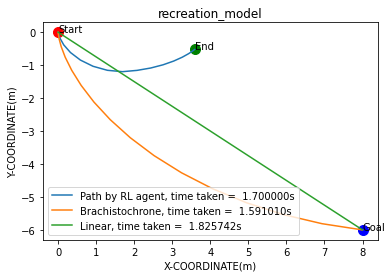

Goal reached! episodic-reward= -67.68262
Steps taken: 17
Time taken:  [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]


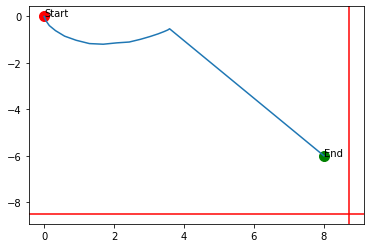

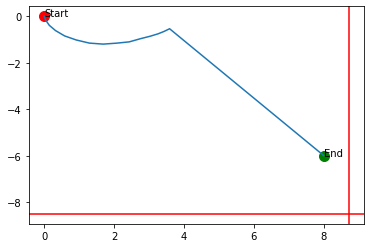

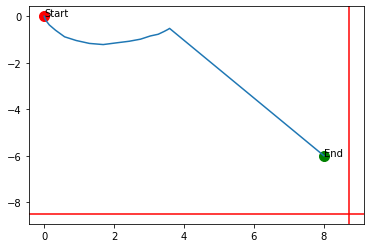

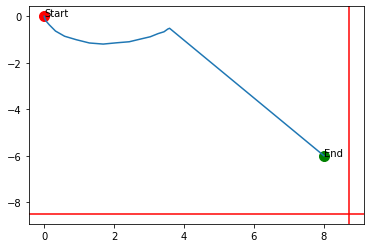

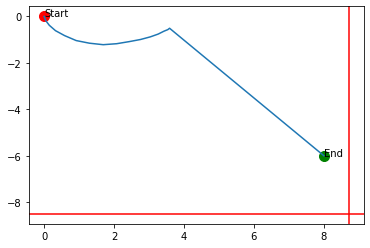

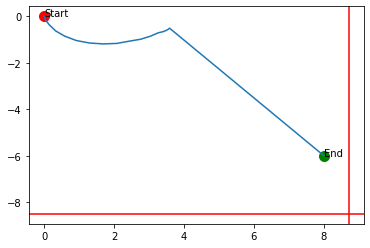

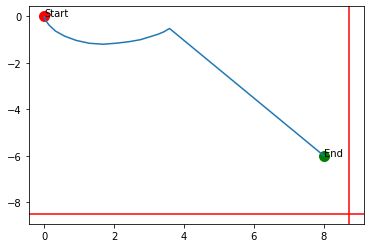

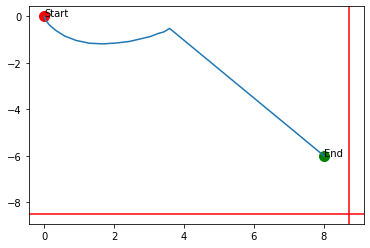

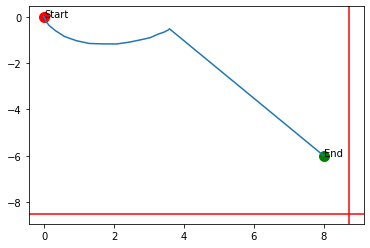

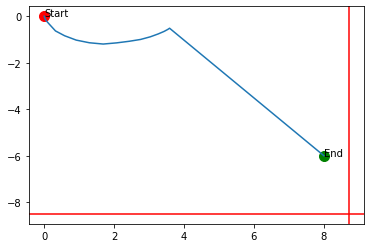

In [17]:
RLOpt = RLBaseSolutionBuilder(Brachistochrone_Env,(8.0, -6.0)) #provide target position for initialization
SELECTED_MODEL = "recreation_model"
change_selected_model()

RLOpt.LoadAgentModel(SELECTED_MODEL) 
#IF YOU WANT YOU CAN TRAIN NEW AGENT FROM SCRATCH -> RLOpt.TrainNewAgent()
RLOpt.TrainNewAgent(model_name = SELECTED_MODEL)
RLOpt.ValidateAgent()#plot the trace corrinsponding to current loaded agent   !!!read me: LoadAgentModel and TrainNewAgent change current loaded model!!!
env = RLOpt.GetEnv()
solution_vector = RLOpt.GetBaseSolution() #get base solution for next pipeline step

#init population generation
opt = OptimizerMiddlewareManager(env,solution_vector,10) #0
opt.base_solution_cast() #1
opt.CreatePopInTranslatedDomain(0.01) #2
opt.TranslatedPopulationRender()



Time taken by cycloid =  1.5910103093924441
Time taken by linear solution =  1.8257418583505538


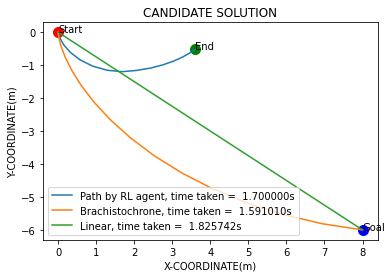

Time taken by cycloid =  1.5910103093924441
Time taken by linear solution =  1.8257418583505538


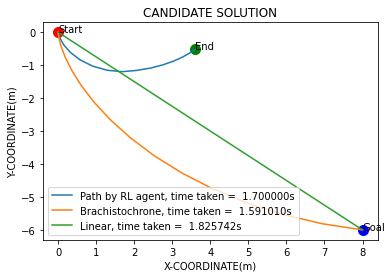

Time taken by cycloid =  1.5910103093924441
Time taken by linear solution =  1.8257418583505538


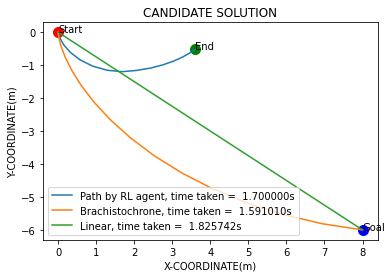

Time taken by cycloid =  1.5910103093924441
Time taken by linear solution =  1.8257418583505538


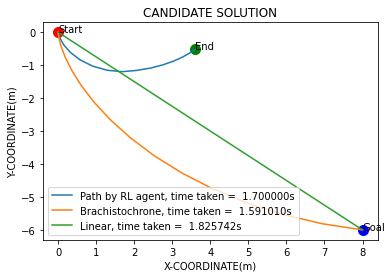

Time taken by cycloid =  1.5910103093924441
Time taken by linear solution =  1.8257418583505538


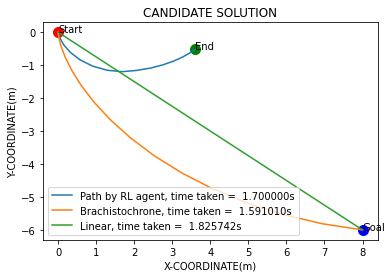

Time taken by cycloid =  1.5910103093924441
Time taken by linear solution =  1.8257418583505538


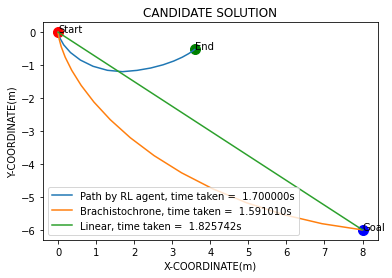

Time taken by cycloid =  1.5910103093924441
Time taken by linear solution =  1.8257418583505538


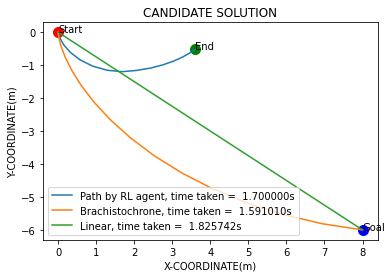

In [19]:
opt.InitialPopulationCreator()
opt.InitialPopulationRender()
opt.ExportPopulationToCSV()


In [20]:
opt.ImportPopulationFromCSV()

In [21]:


print(opt.GetInitPopData()) #3


(array([[[ 0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  9.07273011e-03],
        [ 1.00603476e-02, -2.83851916e-02],
        [ 4.83460762e-02, -1.76356049e-01],
        [ 1.46536872e-01, -3.92445711e-01],
        [ 3.23924690e-01, -6.10943175e-01],
        [ 5.84421635e-01, -8.48422171e-01],
        [ 9.16172981e-01, -1.02639465e+00],
        [ 1.29392743e+00, -1.16859198e+00],
        [ 1.68870401e+00, -1.19602727e+00],
        [ 2.07350874e+00, -1.13834698e+00],
        [ 2.43356633e+00, -1.10142401e+00],
        [ 2.75754142e+00, -9.83511131e-01],
        [ 3.03584170e+00, -8.61424853e-01],
        [ 3.26112795e+00, -7.49296530e-01],
        [ 3.42873573e+00, -6.52594508e-01],
        [ 3.53699398e+00, -5.81547002e-01],
        [ 3.58744764e+00, -5.30526586e-01],
        [ 8.00000000e+00, -6.00000000e+00]],

       [[ 0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00, -2.43175813e-02],
        [ 1.00603476e-02, -4.77000451e-02],
        [ 4.83460762e-02, -1.

## Training and Test Automation 

### Generation of new Training Set (3 Generations)

In [ ]:
#grid hyperparametrization
for Brachistochrone_Env.active_friction in [True,False]:
    for Brachistochrone_Env.dt in [0.1,0.2]:
        for Brachistochrone_Env.init_angle in [-90,-65]:
            for Brachistochrone_Env.sol_space_padding in [1.5,2.5]:
                for Brachistochrone_Env.action_space_padding in [2.0,3.0]:
                    """HYP FOR AGENT TRAINING"""
                    goal = (8.0, -6.0)
                    SELECTED_MODEL = 'generalized_final_3G_nrn_2_'+str(Brachistochrone_Env.active_friction)+'_'+str(Brachistochrone_Env.dt)+'_'+str(Brachistochrone_Env.init_angle)+'_'+str(Brachistochrone_Env.sol_space_padding)+'_'+str(Brachistochrone_Env.action_space_padding)
                    change_selected_model()

                    TOT_STEPS = 150000
                    Brachistochrone_Env.renderOnReset= False
                    """"""""""""
                    env = Brachistochrone_Env()
                    learning_rate_schedule = LinearSchedule(TOT_STEPS,0.000125,0.1)
                    print(env.target_pos)
                    env = make_vec_env(lambda: env, n_envs=1)

                    #wrapping fro obs_space and action_space normalization
                    env = VecNormalize(env, training=True ,norm_obs=True, norm_reward=False)
                    #callback initialization for online update of normalization stats
                    save_vec_normalize = SaveVecNormalizeCallback(save_freq=1, save_path=normalization_path)


                    eval_callback = EvalCallback(env, best_model_save_path=selected_path, callback_on_new_best=save_vec_normalize,
                                                 log_path=log_path, eval_freq=500,
                                                 deterministic=True, render=False)
                    #PPO algorithm is made to discourage radical changes of the policy among differrent episodes, this makes the algorithm more sensible to local minima
                    #provare altri algoritmi PPo2, ACKTR
                    model = PPO('MlpPolicy', env =env, verbose=0,
                                gamma= 0.99, learning_rate=learning_rate_schedule.value,
                                policy_kwargs= dict(net_arch=[600, 600, 300]), tensorboard_log=tensorboard_log)


                    model.learn(total_timesteps=TOT_STEPS, log_interval=1, callback=eval_callback)
                    #build metadata
                    metad = ParseMetadataFile(env_class = Brachistochrone_Env,filepath=hypdict_path)

                    print("<<<END OF %s MODEL TRAINING>>>"%(SELECTED_MODEL))

### Automation Test Results for Normalized input and Rewards

In [ ]:
#grid hyperparametrization
for Brachistochrone_Env.active_friction in [True,False]:
    for Brachistochrone_Env.dt in [0.1,0.2]:
        for Brachistochrone_Env.init_angle in [-90,-65]:
            for Brachistochrone_Env.sol_space_padding in [1.5,2.5]:
                for Brachistochrone_Env.action_space_padding in [2.0,3.0]:
                    goal = (8.0, -6.0)
                    SELECTED_MODEL = 'generalized_final_3G_nrn_2_'+str(Brachistochrone_Env.active_friction)+'_'+str(Brachistochrone_Env.dt)+'_'+str(Brachistochrone_Env.init_angle)+'_'+str(Brachistochrone_Env.sol_space_padding)+str(Brachistochrone_Env.action_space_padding)
                    change_selected_model()

                    #building found optimal path
                    Brachistochrone_Env.renderOnReset=False
                    env = Brachistochrone_Env()
                    env = make_vec_env(lambda: env, n_envs=1)
                    """load stats and env config"""
                    try:
                        #recall statistics for normalizer
                        env = VecNormalize.load(stats_path, env)
                        #  do not update them at test time
                        env.training = False
                        # reward and input-state normalization is not needed at test time
                        env.norm_obs = False
                        env.norm_reward = False
                        """model loading"""
                        model = PPO.load(best_model_path, env=env)
                    except:
                        print("no model found")
                        continue

                    position= [] #list of tuples containing subsequent positions
                    x = [] # x steps
                    y = [] #y values associated
                    steps = 0
                    actions = []
                    observations = []
                    #BUILD SOLUTION
                    #print("Episode {}".format(ep + 1))
                    episodic_reward = []


                    #we have to force target into environment as it must be constant and specified to AI agent

                    obs = env.reset()
                    print("Inital obs: "  +str(obs))

                    """SOLUTION RECONSTRUCTION"""
                    while True:
                        action= model.predict(obs, deterministic = True)
                        obs, reward, done, info = env.step(action)
                        observations.append(obs)
                        new_value = obs[0] #the array from which to extract new piece of path information
                        """new_value[1]: pos_x new_value[2]: pos_y"""
                        position.append((new_value[0],new_value[1]))
                        if done==False:
                            x.append(new_value[0])
                            y.append(new_value[1])
                        episodic_reward.append(reward)
                        actions.append(action)
                        steps+=1
                        #print('obs=', obs, 'reward=', reward, 'done=', done)
                        if done:
                            try:
                                """solution refinement"""
                                #clean last step from the history
                                x.pop()
                                y.pop()
                                position.pop()
                                #check for starting point, sometimes input space normalization makes it lost
                                if (x[0]!=0 or y[0]!=0):
                                    x.insert(0,0)
                                    y.insert(0,0)
                                print(x)
                                print(y)
                                plot_solution(x,y,goal,title=SELECTED_MODEL,savef=True)
                                print("Goal reached!", "episodic-reward=", np.sum(episodic_reward))
                                print("Steps taken: " + str(steps))
                                print("Time taken: " , steps*Brachistochrone_Env.dt)
                            except:
                                print("%s is empty"%(SELECTED_MODEL))
                            break